In [ ]:
#Helper Libraries
import pandas as pd
import random
import numpy as np
from tqdm import tqdm

#Metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_curve, auc

#Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Image and dataset manipulation
from torchvision import transforms, models
from torch.utils.data import random_split, DataLoader

#Image transforms
import cv2
import PIL


## Dowloading dataset
We will download the dataset from kaggle utilizing the API secrets

In [ ]:
from google.colab import userdata #Import colab user secrets
import os #Create environment variable for user secrets

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
#Download and uncompress dataset
!kaggle datasets download -d warcoder/tyre-quality-classification
!unzip "tyre-quality-classification.zip"

100% 2.66G/2.66G [02:20<00:00, 24.3MB/s]
100% 2.66G/2.66G [02:20<00:00, 20.4MB/s]
Archive:  tyre-quality-classification.zip
  inflating: Digital images of defective and good condition tyres/defective/Defective (1).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (10).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (100).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1000).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1001).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1002).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1003).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (1004).jpg  
  inflating: Digital images of defective and good condition tyres/defective/Defective (100

## Obtain dataset images paths
We will organize the images paths and labels in a csv in order to convert them into a custom pytorch dataset later on

In [ ]:
def build_csv(directory_string, output_csv_name):
    """Builds a csv file for pytorch training from a directory of folders of images.
    Install csv module if not already installed.
    Args:
    directory_string: string of directory path, e.g. r'.\data\train'
    output_csv_name: string of output csv file name, e.g. 'train.csv'
    Returns:
    csv file with file names, file paths, class names and class indices
    """
    import csv #Create csv structure and file for cold storage
    directory = directory_string
    class_lst = os.listdir(directory) #returns a LIST containing the names of the entries (folder names in this case) in the directory.
    class_lst.sort()
    with open(output_csv_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['file_name', 'file_path', 'class_name', 'class_index']) #create column names
        for class_name in class_lst:
            class_path = os.path.join(directory, class_name) #concatenates various path components with exactly one directory separator (‘/’) except the last path component.
            file_list = os.listdir(class_path) #get list of files in class folder
            for file_name in file_list:
                file_path = os.path.join(directory, class_name, file_name) #concatenate class folder dir, class name and file name
                writer.writerow([file_name, file_path, class_name, class_lst.index(class_name)]) #write the file path and class name to the csv file
    return

build_csv('/content/Digital images of defective and good condition tyres', 'tires.csv') #build csv file
df = pd.read_csv('tires.csv')#import generate csv file as pandas dataframe for data exploration

In [ ]:
df.head()

,file_name,file_path,class_name,class_index
0,Defective (659).jpg,/content/Digital images of defective and good ...,defective,0
1,Defective (220).jpg,/content/Digital images of defective and good ...,defective,0
2,Defective (903).jpg,/content/Digital images of defective and good ...,defective,0
3,Defective (975).jpg,/content/Digital images of defective and good ...,defective,0
4,Defective (823).jpg,/content/Digital images of defective and good ...,defective,0


In [ ]:
df.tail()

,file_name,file_path,class_name,class_index
1851,good (51).jpg,/content/Digital images of defective and good ...,good,1
1852,good (803).jpg,/content/Digital images of defective and good ...,good,1
1853,good (636).jpg,/content/Digital images of defective and good ...,good,1
1854,good (709).jpg,/content/Digital images of defective and good ...,good,1
1855,good (430).jpg,/content/Digital images of defective and good ...,good,1


Check label encodings

In [ ]:
class_zip = zip(df['class_index'], df['class_name'])
my_list = []
for index, name in class_zip:
  tup = tuple((index, name))
  my_list.append(tup)
unique_list = list(set(my_list))
print('Data Labels:')
print(sorted(unique_list))
print()

Data Labels:
[(0, 'defective'), (1, 'good')]



Check unique labels

In [ ]:
class_names = list(df['class_name'].unique())
class_names

['defective', 'good']

## Creating the custom dataset class

In [ ]:
class TiresDataset(torch.utils.data.Dataset): #inheritin from Dataset class
    def __init__(self, csv_file, root_dir="", transform=None):
        self.annotation_df = pd.read_csv(csv_file)
        self.root_dir = root_dir #root directory of images, leave "" if using the image path column in the __getitem__ method
        self.transform = transform

    def __len__(self):
        return len(self.annotation_df) #return length (numer of rows) of the dataframe

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.annotation_df.iloc[idx, 1]) #use image path column (index = 1) in csv file
        image = cv2.imread(image_path) #read image by cv2
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert from BGR to RGB for matplotlib
        class_name = self.annotation_df.iloc[idx, 2] #use class name column (index = 2) in csv file
        class_index = self.annotation_df.iloc[idx, 3] #use class index column (index = 3) in csv file
        if self.transform:
            image = self.transform(image)
        return image, class_name, class_index

## Data exploration

In [ ]:
dataset_untransformed = TiresDataset(csv_file='tires.csv', root_dir="", transform=None) #create custom pytorch dataset without transforms

Untransformed dataset random samples visualization

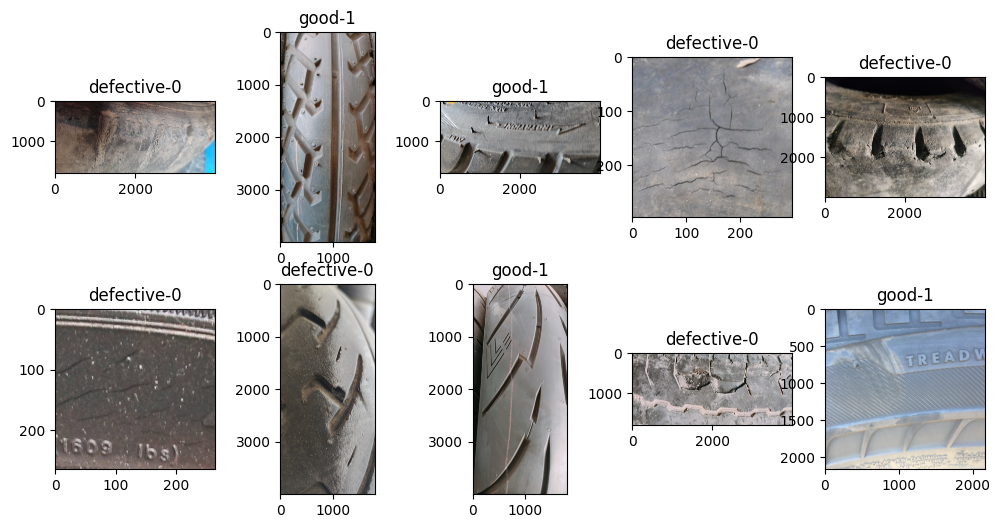

In [ ]:
plt.figure(figsize=(12,6))
for i in range(10):
    idx = random.randint(0, len(dataset_untransformed))
    image, class_name, class_index = dataset_untransformed[idx]
    ax=plt.subplot(2,5,i+1) #create an axis
    ax.title.set_text(class_name + '-' + str(class_index)) #create a name of the axis based on the img name
    plt.imshow(image) #show the img

the untransformed dataset will need to be adjusted in order to fit the expected values for the prebuilt model

In [ ]:
#Memory cleaning
del dataset_untransformed

apply resnet expected transforms

In [ ]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

In [ ]:
dataset_transformed = TiresDataset(csv_file='tires.csv', root_dir="", transform=transform) #Recreate custom dataset with ResNet transforms

Transformed dataset random saples visualization

<ipython-input-15-09b96558b4b3>:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  plt.imshow(image.T) # show the img


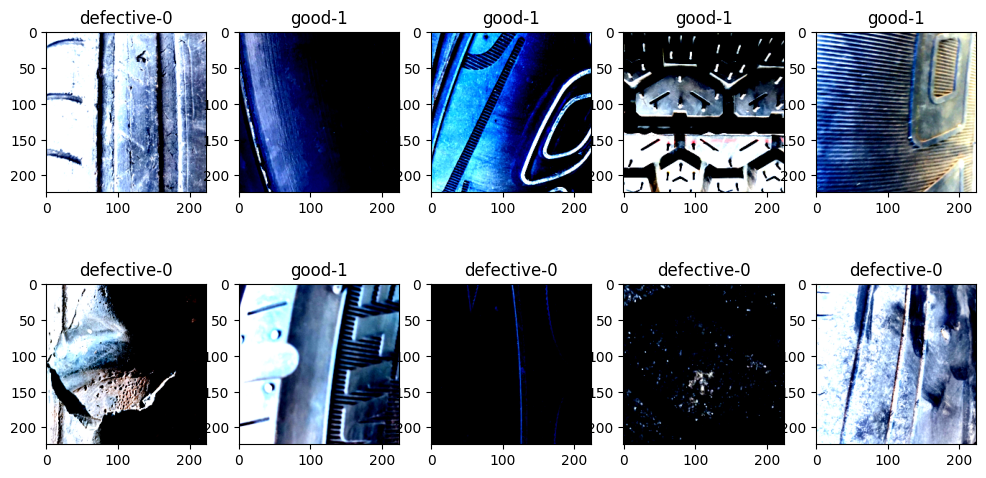

In [ ]:
plt.figure(figsize=(12,6))
for i in range(10):
    idx = random.randint(0, len(dataset_transformed))
    image, class_name, class_index = dataset_transformed[idx]
    ax=plt.subplot(2,5,i+1) #create an axis
    ax.title.set_text(class_name + '-' + str(class_index)) #create a name of the axis based on the img name
    plt.imshow(image.T) #show the img

## Model training

### Device setup

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.seed()
torch.cuda.seed()

### Hyperparameters

In [ ]:
batch_size = 64
learning_rate = 0.001
num_epochs = 10

### Data loaders

In [ ]:
trainset, valset, testset = random_split(dataset_transformed,[0.7,0.1,0.2])

In [ ]:
len(trainset), len(valset), len(testset)

(1300, 185, 371)

In [ ]:
trainloader =  DataLoader(dataset = trainset, batch_size = batch_size, num_workers= 2, shuffle=True)
valloader =  DataLoader(dataset = valset, batch_size = batch_size, num_workers= 2, shuffle=True)
testloader =  DataLoader(dataset = testset, batch_size = batch_size, num_workers= 2, shuffle=False)

### Pretrained model preparation

In [ ]:
model152 = models.resnet152(pretrained=True) #Load prebuilt model

#Freeze layers
for param in model152.parameters():
    param.requires_grad = False

#Change final fc layer to dense layer of output 2
num_ftrs = model152.fc.in_features
model152.fc = nn.Linear(num_ftrs, 2)

#Unfreeze last layer
for param in model152.fc.parameters():
    param.requires_grad = True

#Send model to device
model152 =  model152.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 193MB/s]


In [ ]:
criterion152 = nn.CrossEntropyLoss() #No softmax activation in linear layer, user cross entropy
optimizer152 = optim.Adam(model152.parameters(), lr=learning_rate) #Using ADAM optimizer as baseline

In [ ]:
model34 = models.resnet34(pretrained=True) #Load prebuilt model

#Freeze layers
for param in model34.parameters():
    param.requires_grad = False

#Change final fc layer to dense layer of output 2
num_ftrs = model34.fc.in_features
model34.fc = nn.Linear(num_ftrs, 2)
#Unfreeze last layer
for param in model34.fc.parameters():
    param.requires_grad = True

#Send model to device
model34 =  model34.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 183MB/s]


In [ ]:
criterion34 = nn.CrossEntropyLoss() #No softmax activation in linear layer, user cross entropy
optimizer34 = optim.Adam(model34.parameters(), lr=learning_rate) #Using ADAM optimizer as baseline

### Training loop

#### Resnet 34

In [ ]:
optimizer = optimizer34 #Setting optimizer to the current model's optimizer
criterion = criterion34 #Setting criterion variable to the current model's loss function
model = model34 #Setting model variable to the current model

In [ ]:
# Lists for loss and accuracy to plot later
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []
train_counter = []
val_counter = [i*len(trainloader.dataset) for i in range(num_epochs)] #Convert length of validation points proyection to the same length of training dataset

for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        #Get batch
        inputs, cats, labels =  data
        inputs, labels = inputs.to(device) ,labels.to(device)

        optimizer.zero_grad()

        #Feed forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        #Backpropagation
        loss.backward()
        optimizer.step()

        #Get batch metrics
        total += labels.size(0)
        _, preds = torch.max(outputs.data, 1)
        running_loss += loss.item() * inputs.size(0)
        correct += torch.sum(preds == labels.data)

        # print & accumulate training statistics (loss & accuracy) every 5 iterations (batches)
        if i % 5 == 0 and i > 0:
          accuracy_iter = 100 * correct.double() / total
          accuracy_iter = accuracy_iter.cpu()
          loss_iter = running_loss / total
          train_losses.append(loss_iter)
          train_accuracy.append(accuracy_iter)
          train_counter.append((i*4) + ((epoch)*len(trainloader.dataset)))
          if i == 0: #Skip first iteration for smoother visualizations
            print()
          print('Training Stats Iteration - Epoch: {} Iteration: {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, i, loss_iter, accuracy_iter))


    #Calculate epoch metrics
    epoch_accuracy = 100 * correct.double() / len(trainset)
    epoch_loss = running_loss / len(trainset)
    print('Training Stats Epoch - Epoch: {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_accuracy))

    model.eval() #Change to eval mode

    #Evaluate on validation dataset
    with torch.no_grad():
      correct_val= 0
      running_loss_val = 0
      lossVal = 0
      accuracyVal = 0
      for i, data in enumerate(valloader, 0):
          inputs, cats, labels =  data
          inputs, labels = inputs.to(device) ,labels.to(device)

          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs.data, 1)
          running_loss_val += loss.item() * inputs.size(0)
          correct_val += torch.sum(preds == labels.data)

      lossVal = running_loss_val / len(valset)
      accuracyVal = 100 * correct_val.double() / len(valset)
      accuracyVal = accuracyVal.cpu()
      val_losses.append(lossVal)
      val_accuracy.append(accuracyVal)
      print()
      print('Validation Stats - Epoch: {} Iteration: {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, i, lossVal, accuracyVal))
      print()

    model.train()#Return model to train mode

print('Finished Training')

  0%|          | 0/10 [00:00<?, ?it/s]

Training Stats Iteration - Epoch: 0 Iteration: 5 Loss: 0.8476 Acc: 53.9062
Training Stats Iteration - Epoch: 0 Iteration: 10 Loss: 0.7681 Acc: 58.0966
Training Stats Iteration - Epoch: 0 Iteration: 15 Loss: 0.7135 Acc: 62.3047
Training Stats Iteration - Epoch: 0 Iteration: 20 Loss: 0.6712 Acc: 65.3077
Training Stats Epoch - Epoch: 0 Loss: 0.6712 Acc: 65.3077


 10%|█         | 1/10 [01:18<11:46, 78.46s/it]


Validation Stats - Epoch: 0 Iteration: 2 Loss: 0.5418 Acc: 70.2703

Training Stats Iteration - Epoch: 1 Iteration: 5 Loss: 0.4503 Acc: 80.4688
Training Stats Iteration - Epoch: 1 Iteration: 10 Loss: 0.4320 Acc: 81.5341
Training Stats Iteration - Epoch: 1 Iteration: 15 Loss: 0.4258 Acc: 81.7383
Training Stats Iteration - Epoch: 1 Iteration: 20 Loss: 0.4162 Acc: 82.3077
Training Stats Epoch - Epoch: 1 Loss: 0.4162 Acc: 82.3077


 20%|██        | 2/10 [02:38<10:33, 79.14s/it]


Validation Stats - Epoch: 1 Iteration: 2 Loss: 0.4021 Acc: 85.9459

Training Stats Iteration - Epoch: 2 Iteration: 5 Loss: 0.3426 Acc: 87.2396
Training Stats Iteration - Epoch: 2 Iteration: 10 Loss: 0.3584 Acc: 84.3750
Training Stats Iteration - Epoch: 2 Iteration: 15 Loss: 0.3576 Acc: 85.1562
Training Stats Iteration - Epoch: 2 Iteration: 20 Loss: 0.3595 Acc: 85.0769
Training Stats Epoch - Epoch: 2 Loss: 0.3595 Acc: 85.0769


 30%|███       | 3/10 [03:59<09:19, 79.99s/it]


Validation Stats - Epoch: 2 Iteration: 2 Loss: 0.3954 Acc: 81.6216

Training Stats Iteration - Epoch: 3 Iteration: 5 Loss: 0.3290 Acc: 86.1979
Training Stats Iteration - Epoch: 3 Iteration: 10 Loss: 0.3199 Acc: 85.9375
Training Stats Iteration - Epoch: 3 Iteration: 15 Loss: 0.3236 Acc: 85.6445
Training Stats Iteration - Epoch: 3 Iteration: 20 Loss: 0.3172 Acc: 85.8462
Training Stats Epoch - Epoch: 3 Loss: 0.3172 Acc: 85.8462


 40%|████      | 4/10 [05:18<07:57, 79.58s/it]


Validation Stats - Epoch: 3 Iteration: 2 Loss: 0.3269 Acc: 86.4865

Training Stats Iteration - Epoch: 4 Iteration: 5 Loss: 0.2765 Acc: 90.3646
Training Stats Iteration - Epoch: 4 Iteration: 10 Loss: 0.2810 Acc: 88.6364
Training Stats Iteration - Epoch: 4 Iteration: 15 Loss: 0.2729 Acc: 89.0625
Training Stats Iteration - Epoch: 4 Iteration: 20 Loss: 0.2852 Acc: 88.0000
Training Stats Epoch - Epoch: 4 Loss: 0.2852 Acc: 88.0000


 50%|█████     | 5/10 [06:37<06:37, 79.51s/it]


Validation Stats - Epoch: 4 Iteration: 2 Loss: 0.3139 Acc: 85.9459

Training Stats Iteration - Epoch: 5 Iteration: 5 Loss: 0.3272 Acc: 85.9375
Training Stats Iteration - Epoch: 5 Iteration: 10 Loss: 0.2937 Acc: 87.7841
Training Stats Iteration - Epoch: 5 Iteration: 15 Loss: 0.2918 Acc: 87.9883
Training Stats Iteration - Epoch: 5 Iteration: 20 Loss: 0.2841 Acc: 88.0000
Training Stats Epoch - Epoch: 5 Loss: 0.2841 Acc: 88.0000


 60%|██████    | 6/10 [07:56<05:17, 79.35s/it]


Validation Stats - Epoch: 5 Iteration: 2 Loss: 0.3318 Acc: 84.3243

Training Stats Iteration - Epoch: 6 Iteration: 5 Loss: 0.3070 Acc: 87.2396
Training Stats Iteration - Epoch: 6 Iteration: 10 Loss: 0.2975 Acc: 88.7784
Training Stats Iteration - Epoch: 6 Iteration: 15 Loss: 0.2752 Acc: 89.3555
Training Stats Iteration - Epoch: 6 Iteration: 20 Loss: 0.2649 Acc: 89.6154
Training Stats Epoch - Epoch: 6 Loss: 0.2649 Acc: 89.6154


 70%|███████   | 7/10 [09:15<03:57, 79.29s/it]


Validation Stats - Epoch: 6 Iteration: 2 Loss: 0.2769 Acc: 87.0270

Training Stats Iteration - Epoch: 7 Iteration: 5 Loss: 0.2502 Acc: 91.9271
Training Stats Iteration - Epoch: 7 Iteration: 10 Loss: 0.2705 Acc: 89.9148
Training Stats Iteration - Epoch: 7 Iteration: 15 Loss: 0.2515 Acc: 90.3320
Training Stats Iteration - Epoch: 7 Iteration: 20 Loss: 0.2465 Acc: 90.0000
Training Stats Epoch - Epoch: 7 Loss: 0.2465 Acc: 90.0000


 80%|████████  | 8/10 [10:34<02:38, 79.08s/it]


Validation Stats - Epoch: 7 Iteration: 2 Loss: 0.2752 Acc: 86.4865

Training Stats Iteration - Epoch: 8 Iteration: 5 Loss: 0.2327 Acc: 90.1042
Training Stats Iteration - Epoch: 8 Iteration: 10 Loss: 0.2414 Acc: 89.3466
Training Stats Iteration - Epoch: 8 Iteration: 15 Loss: 0.2436 Acc: 89.6484
Training Stats Iteration - Epoch: 8 Iteration: 20 Loss: 0.2409 Acc: 90.0000
Training Stats Epoch - Epoch: 8 Loss: 0.2409 Acc: 90.0000


 90%|█████████ | 9/10 [11:53<01:19, 79.21s/it]


Validation Stats - Epoch: 8 Iteration: 2 Loss: 0.2737 Acc: 85.9459

Training Stats Iteration - Epoch: 9 Iteration: 5 Loss: 0.2377 Acc: 90.6250
Training Stats Iteration - Epoch: 9 Iteration: 10 Loss: 0.2325 Acc: 90.4830
Training Stats Iteration - Epoch: 9 Iteration: 15 Loss: 0.2314 Acc: 90.8203
Training Stats Iteration - Epoch: 9 Iteration: 20 Loss: 0.2287 Acc: 90.6923
Training Stats Epoch - Epoch: 9 Loss: 0.2287 Acc: 90.6923


100%|██████████| 10/10 [13:13<00:00, 79.32s/it]


Validation Stats - Epoch: 9 Iteration: 2 Loss: 0.2498 Acc: 89.1892

Finished Training


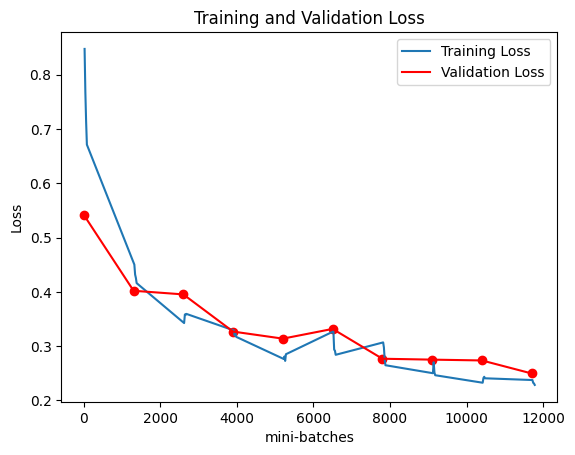

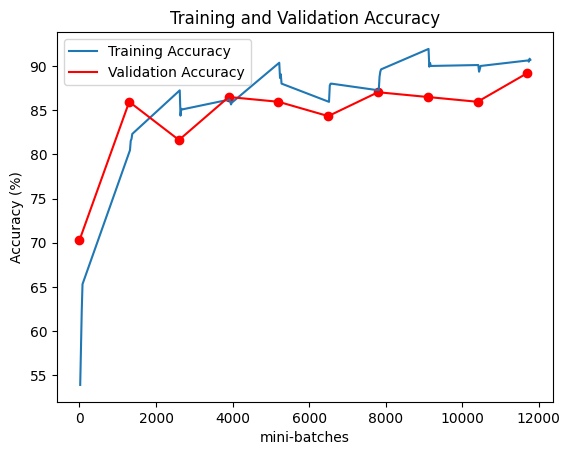

In [ ]:
# Plot training loss over time
plt.figure()
plt.plot(train_counter, train_losses, label='Training Loss')
plt.scatter(val_counter, val_losses,color='red')
plt.plot(val_counter, val_losses, label='Validation Loss',color='red')
plt.title('Training and Validation Loss')
plt.xlabel('mini-batches')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy over time
plt.figure()
plt.plot(train_counter, train_accuracy, label='Training Accuracy')
plt.scatter(val_counter, val_accuracy,color='red')
plt.plot(val_counter, val_accuracy, label='Validation Accuracy',color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('mini-batches')
plt.ylabel('Accuracy (%)')
plt.legend()

##### Model Testing

In [ ]:
y_true = []
y_pred = []
running_loss_test = 0
correct_test = 0

model.eval()

with torch.no_grad():
    for i, data in enumerate(tqdm(testloader), 0):
        inputs, cats, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        y_true.append(labels.cpu())
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        y_pred.append(preds.cpu())
        correct_test += torch.sum(preds == labels.data)

accuracyTest = 100 * correct_test.double() / len(testset)

100%|██████████| 6/6 [00:19<00:00,  3.33s/it]


##### Model metrics and visualizations

In [ ]:
y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)

In [ ]:
# Print scores
print(classification_report(y_true, y_pred, labels=[0,1], target_names=['defective','good']))

              precision    recall  f1-score   support

   defective       0.94      0.91      0.92       213
        good       0.88      0.92      0.90       158

    accuracy                           0.91       371
   macro avg       0.91      0.91      0.91       371
weighted avg       0.91      0.91      0.91       371



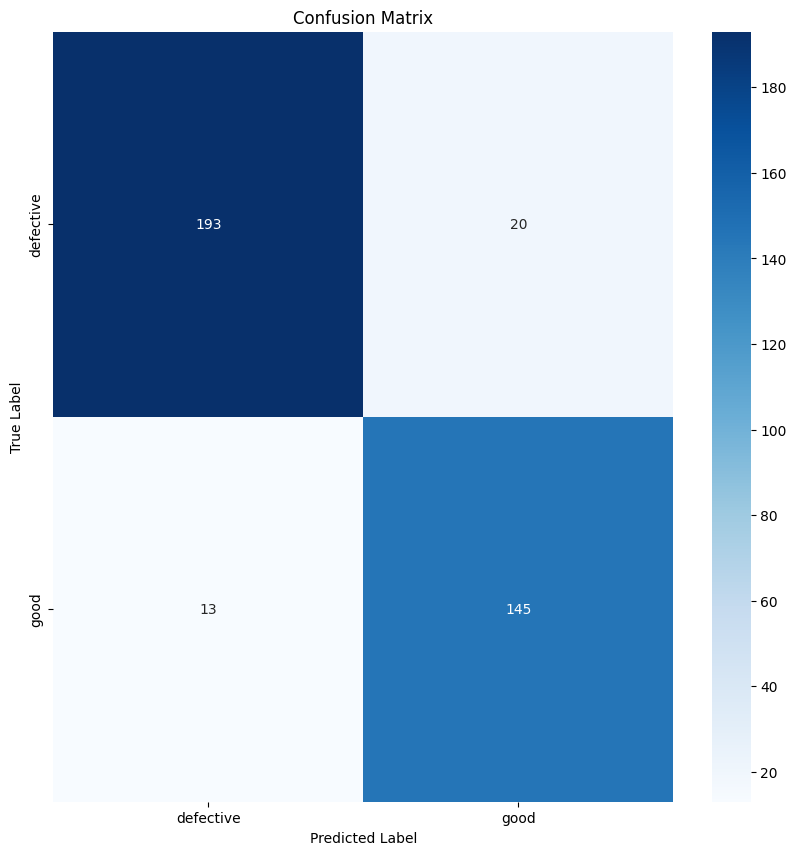

In [ ]:
# Find and plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)# <<<<<<< your code here >>>>>>>>
plt.figure(figsize=(10,10))
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['defective','good']); ax.yaxis.set_ticklabels(['defective','good']);
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

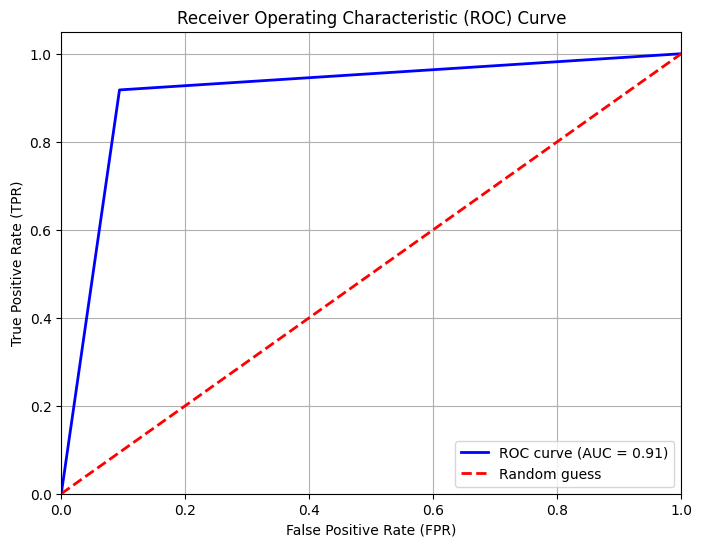

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Resnet152

In [ ]:
optimizer = optimizer152
criterion = criterion152
model = model152

In [ ]:
# Lists for loss and accuracy to plot later
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []
train_counter = []
val_counter = [i*len(trainloader.dataset) for i in range(num_epochs)]

for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, cats, labels =  data
        inputs, labels = inputs.to(device) ,labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total += labels.size(0)
        _, preds = torch.max(outputs.data, 1)
        running_loss += loss.item() * inputs.size(0)
        correct += torch.sum(preds == labels.data)

        # print & accumulate training statistics (loss & accuracy) every 5 iterations
        if i % 5 == 0 and i > 0:
          accuracy_iter = 100 * correct.double() / total
          accuracy_iter = accuracy_iter.cpu()
          loss_iter = running_loss / total
          train_losses.append(loss_iter)
          train_accuracy.append(accuracy_iter)
          train_counter.append((i*4) + ((epoch)*len(trainloader.dataset)))
          if i == 0:
            print()
          print('Training Stats Iteration - Epoch: {} Iteration: {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, i, loss_iter, accuracy_iter))



    epoch_accuracy = 100 * correct.double() / len(trainset)
    epoch_loss = running_loss / len(trainset)
    print('Training Stats Epoch - Epoch: {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_accuracy))

    model.eval()

    with torch.no_grad():
      correct_val= 0
      running_loss_val = 0
      lossVal = 0
      accuracyVal = 0
      for i, data in enumerate(valloader, 0):
          inputs, cats, labels =  data
          inputs, labels = inputs.to(device) ,labels.to(device)

          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs.data, 1)
          running_loss_val += loss.item() * inputs.size(0)
          correct_val += torch.sum(preds == labels.data)

      lossVal = running_loss_val / len(valset)
      accuracyVal = 100 * correct_val.double() / len(valset)
      accuracyVal = accuracyVal.cpu()
      val_losses.append(lossVal)
      val_accuracy.append(accuracyVal)
      print()
      print('Validation Stats - Epoch: {} Iteration: {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, i, lossVal, accuracyVal))
      print()

    model.train()

print('Finished Training')

  0%|          | 0/10 [00:00<?, ?it/s]

Training Stats Iteration - Epoch: 0 Iteration: 5 Loss: 0.6030 Acc: 69.7917
Training Stats Iteration - Epoch: 0 Iteration: 10 Loss: 0.4971 Acc: 77.8409
Training Stats Iteration - Epoch: 0 Iteration: 15 Loss: 0.4391 Acc: 81.1523
Training Stats Iteration - Epoch: 0 Iteration: 20 Loss: 0.4211 Acc: 81.6154
Training Stats Epoch - Epoch: 0 Loss: 0.4211 Acc: 81.6154


 10%|█         | 1/10 [01:19<11:53, 79.22s/it]


Validation Stats - Epoch: 0 Iteration: 2 Loss: 0.3087 Acc: 87.5676

Training Stats Iteration - Epoch: 1 Iteration: 5 Loss: 0.3111 Acc: 87.2396
Training Stats Iteration - Epoch: 1 Iteration: 10 Loss: 0.3023 Acc: 87.0739
Training Stats Iteration - Epoch: 1 Iteration: 15 Loss: 0.3025 Acc: 86.7188
Training Stats Iteration - Epoch: 1 Iteration: 20 Loss: 0.2969 Acc: 87.3077
Training Stats Epoch - Epoch: 1 Loss: 0.2969 Acc: 87.3077


 20%|██        | 2/10 [02:38<10:34, 79.31s/it]


Validation Stats - Epoch: 1 Iteration: 2 Loss: 0.2598 Acc: 87.0270

Training Stats Iteration - Epoch: 2 Iteration: 5 Loss: 0.2262 Acc: 89.5833
Training Stats Iteration - Epoch: 2 Iteration: 10 Loss: 0.2183 Acc: 90.6250
Training Stats Iteration - Epoch: 2 Iteration: 15 Loss: 0.2228 Acc: 90.6250
Training Stats Iteration - Epoch: 2 Iteration: 20 Loss: 0.2144 Acc: 91.2308
Training Stats Epoch - Epoch: 2 Loss: 0.2144 Acc: 91.2308


 30%|███       | 3/10 [03:58<09:16, 79.52s/it]


Validation Stats - Epoch: 2 Iteration: 2 Loss: 0.2205 Acc: 91.3514

Training Stats Iteration - Epoch: 3 Iteration: 5 Loss: 0.2072 Acc: 90.6250
Training Stats Iteration - Epoch: 3 Iteration: 10 Loss: 0.2206 Acc: 91.1932
Training Stats Iteration - Epoch: 3 Iteration: 15 Loss: 0.2020 Acc: 92.4805
Training Stats Iteration - Epoch: 3 Iteration: 20 Loss: 0.2060 Acc: 91.7692
Training Stats Epoch - Epoch: 3 Loss: 0.2060 Acc: 91.7692


 40%|████      | 4/10 [05:16<07:52, 78.83s/it]


Validation Stats - Epoch: 3 Iteration: 2 Loss: 0.2153 Acc: 91.3514

Training Stats Iteration - Epoch: 4 Iteration: 5 Loss: 0.2252 Acc: 90.1042
Training Stats Iteration - Epoch: 4 Iteration: 10 Loss: 0.1951 Acc: 92.3295
Training Stats Iteration - Epoch: 4 Iteration: 15 Loss: 0.1896 Acc: 92.4805
Training Stats Iteration - Epoch: 4 Iteration: 20 Loss: 0.1878 Acc: 92.8462
Training Stats Epoch - Epoch: 4 Loss: 0.1878 Acc: 92.8462


 50%|█████     | 5/10 [06:36<06:37, 79.46s/it]


Validation Stats - Epoch: 4 Iteration: 2 Loss: 0.2081 Acc: 90.8108

Training Stats Iteration - Epoch: 5 Iteration: 5 Loss: 0.1930 Acc: 92.7083
Training Stats Iteration - Epoch: 5 Iteration: 10 Loss: 0.1791 Acc: 93.1818
Training Stats Iteration - Epoch: 5 Iteration: 15 Loss: 0.1805 Acc: 92.8711
Training Stats Iteration - Epoch: 5 Iteration: 20 Loss: 0.1708 Acc: 93.4615
Training Stats Epoch - Epoch: 5 Loss: 0.1708 Acc: 93.4615


 60%|██████    | 6/10 [07:57<05:20, 80.08s/it]


Validation Stats - Epoch: 5 Iteration: 2 Loss: 0.1895 Acc: 91.8919

Training Stats Iteration - Epoch: 6 Iteration: 5 Loss: 0.1911 Acc: 92.9688
Training Stats Iteration - Epoch: 6 Iteration: 10 Loss: 0.1745 Acc: 93.7500
Training Stats Iteration - Epoch: 6 Iteration: 15 Loss: 0.1695 Acc: 94.1406
Training Stats Iteration - Epoch: 6 Iteration: 20 Loss: 0.1708 Acc: 93.3846
Training Stats Epoch - Epoch: 6 Loss: 0.1708 Acc: 93.3846


 70%|███████   | 7/10 [09:16<03:58, 79.55s/it]


Validation Stats - Epoch: 6 Iteration: 2 Loss: 0.1788 Acc: 93.5135

Training Stats Iteration - Epoch: 7 Iteration: 5 Loss: 0.1569 Acc: 94.0104
Training Stats Iteration - Epoch: 7 Iteration: 10 Loss: 0.1574 Acc: 94.0341
Training Stats Iteration - Epoch: 7 Iteration: 15 Loss: 0.1704 Acc: 93.0664
Training Stats Iteration - Epoch: 7 Iteration: 20 Loss: 0.1707 Acc: 93.1538
Training Stats Epoch - Epoch: 7 Loss: 0.1707 Acc: 93.1538


 80%|████████  | 8/10 [10:35<02:38, 79.27s/it]


Validation Stats - Epoch: 7 Iteration: 2 Loss: 0.1738 Acc: 92.9730

Training Stats Iteration - Epoch: 8 Iteration: 5 Loss: 0.1305 Acc: 94.7917
Training Stats Iteration - Epoch: 8 Iteration: 10 Loss: 0.1388 Acc: 94.7443
Training Stats Iteration - Epoch: 8 Iteration: 15 Loss: 0.1438 Acc: 94.3359
Training Stats Iteration - Epoch: 8 Iteration: 20 Loss: 0.1496 Acc: 94.0769
Training Stats Epoch - Epoch: 8 Loss: 0.1496 Acc: 94.0769


 90%|█████████ | 9/10 [11:53<01:19, 79.04s/it]


Validation Stats - Epoch: 8 Iteration: 2 Loss: 0.1696 Acc: 94.5946

Training Stats Iteration - Epoch: 9 Iteration: 5 Loss: 0.1434 Acc: 95.3125
Training Stats Iteration - Epoch: 9 Iteration: 10 Loss: 0.1504 Acc: 94.6023
Training Stats Iteration - Epoch: 9 Iteration: 15 Loss: 0.1443 Acc: 94.9219
Training Stats Iteration - Epoch: 9 Iteration: 20 Loss: 0.1489 Acc: 94.8462
Training Stats Epoch - Epoch: 9 Loss: 0.1489 Acc: 94.8462


100%|██████████| 10/10 [13:13<00:00, 79.32s/it]


Validation Stats - Epoch: 9 Iteration: 2 Loss: 0.1939 Acc: 91.8919

Finished Training


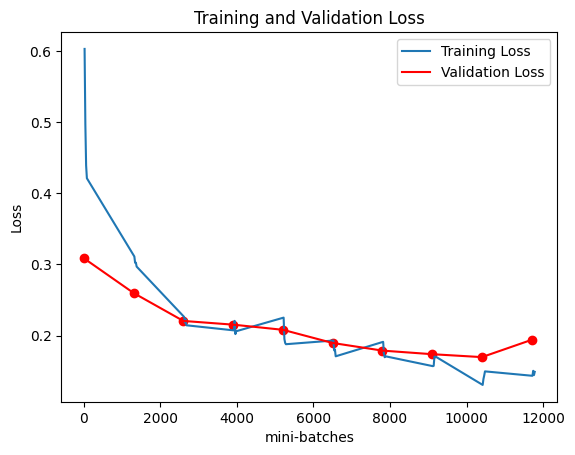

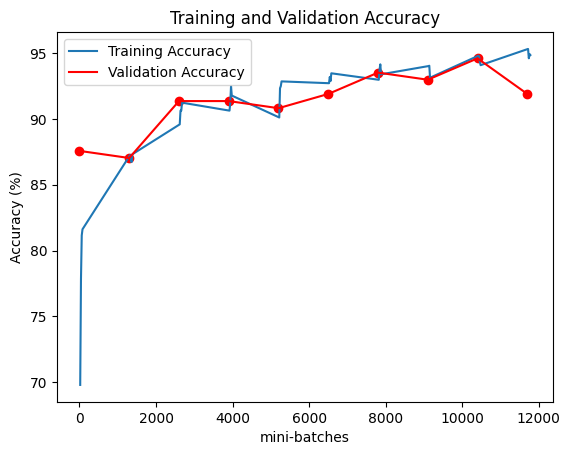

In [ ]:
# Plot training loss over time
plt.figure()
plt.plot(train_counter, train_losses, label='Training Loss')
plt.scatter(val_counter, val_losses,color='red')
plt.plot(val_counter, val_losses, label='Validation Loss',color='red')
plt.title('Training and Validation Loss')
plt.xlabel('mini-batches')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy over time
plt.figure()
plt.plot(train_counter, train_accuracy, label='Training Accuracy')
plt.scatter(val_counter, val_accuracy,color='red')
plt.plot(val_counter, val_accuracy, label='Validation Accuracy',color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('mini-batches')
plt.ylabel('Accuracy (%)')
plt.legend()

##### Model Testing

In [ ]:
y_true = []
y_pred = []
running_loss_test = 0
correct_test = 0

model.eval()

with torch.no_grad():
    for i, data in enumerate(tqdm(testloader), 0):
        inputs, cats, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        y_true.append(labels.cpu())
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        y_pred.append(preds.cpu())
        correct_test += torch.sum(preds == labels.data)

accuracyTest = 100 * correct_test.double() / len(testset)

100%|██████████| 6/6 [00:20<00:00,  3.37s/it]


##### Model metrics and visualizations

In [ ]:
y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)

In [ ]:
# Print F1 score
print(classification_report(y_true, y_pred, labels=[0,1], target_names=['defective','good']))

              precision    recall  f1-score   support

   defective       0.98      0.91      0.94       213
        good       0.89      0.97      0.93       158

    accuracy                           0.94       371
   macro avg       0.93      0.94      0.94       371
weighted avg       0.94      0.94      0.94       371



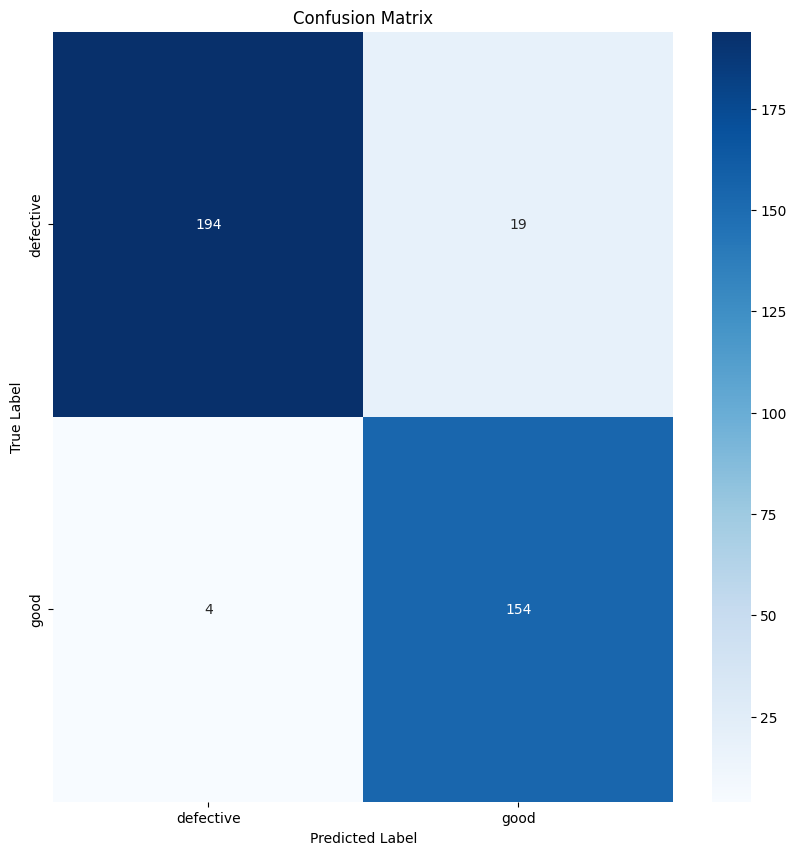

In [ ]:
# Find and plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)# <<<<<<< your code here >>>>>>>>
plt.figure(figsize=(10,10))
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['defective','good']); ax.yaxis.set_ticklabels(['defective','good']);
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

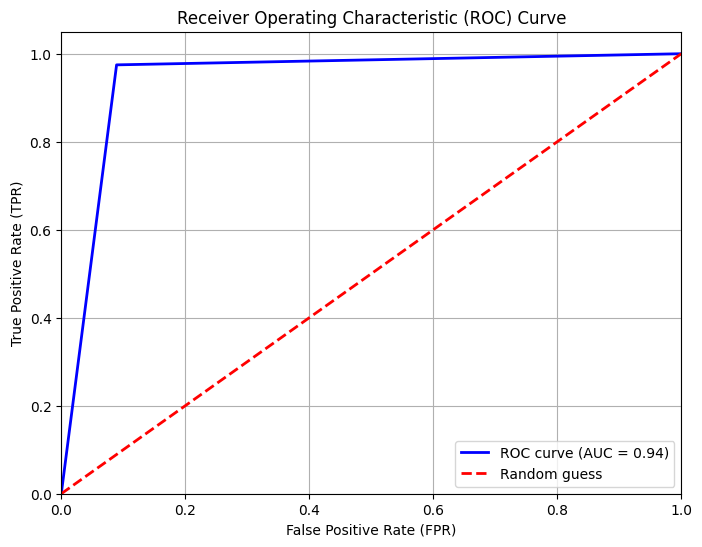

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()